In [1]:
import os
import zipfile
import shutil
import time
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt

# --- Configuration ---
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

BATCH_SIZE = 64
LR = 0.001
EPOCHS = 10
HIDDEN_DIM = 512

# Define a path for our data
DATA_DIR = "tiny-imagenet-data"
SUBSET_DIR = "tiny-imagenet-data"

ZIP_FILE = 'tiny-imagenet.zip'

Using device: cpu


In [2]:
# ============================================================
# FUNCTION: CHECK & UNZIP DATASET
# ============================================================

def unzip_dataset_if_needed(zip_path, extract_to, extracted_folder_name):
    """
    Checks if dataset already extracted.
    If not → unzip automatically.
    """

    extracted_path = os.path.join(extract_to, extracted_folder_name)

    # check if already extracted
    if not os.path.exists(extracted_path):
        print(f"Dataset not found. Unzipping {zip_path}...")

        with zipfile.ZipFile(zip_path, 'r') as zip_ref:
            zip_ref.extractall(extract_to)

        print("Unzipping complete ✔")

    else:
        print("Dataset already unzipped ✔")

    return extracted_path

BASE_PATH = unzip_dataset_if_needed(
    zip_path=ZIP_FILE,
    extract_to=DATA_DIR,
    extracted_folder_name=""


)

print("Base dataset path:", BASE_PATH)

Dataset already unzipped ✔
Base dataset path: tiny-imagenet-data/


In [3]:
def reformat_tinyimagenet_val(BASE_PATH):
    val_dir = os.path.join(BASE_PATH, "val")
    annotations_path = os.path.join(val_dir, "val_annotations.txt")
    images_dir = os.path.join(val_dir, "images")

    # If already formatted
    if not os.path.exists(annotations_path):
        print("Validation directory already seems reformatted.")
        return

    print("Reformatting validation directory...")

    # Read annotation file
    df = pd.read_csv(
        annotations_path,
        sep="\t",
        header=None,
        names=["file", "class", "x1", "y1", "x2", "y2"]
    )

    # Move images into class folders
    for file_name, class_name in zip(df["file"], df["class"]):
        class_folder = os.path.join(val_dir, class_name)
        os.makedirs(class_folder, exist_ok=True)

        src = os.path.join(images_dir, file_name)
        dst = os.path.join(class_folder, file_name)

        if os.path.exists(src):
            shutil.move(src, dst)

    # Delete annotation file
    if os.path.exists(annotations_path):
        os.remove(annotations_path)

    # Delete images folder if empty
    if os.path.exists(images_dir) and len(os.listdir(images_dir)) == 0:
        os.rmdir(images_dir)

    print("Validation directory reformatted.")

In [4]:
def create_subset_dataset(BASE_PATH, SUBSET_DIR, num_classes=10):

    train_dir = os.path.join(BASE_PATH, "train")
    val_dir   = os.path.join(BASE_PATH, "val")

    # Check train folder
    if not os.path.exists(train_dir):
        raise FileNotFoundError(f"Train folder not found: {train_dir}")

    # Get all class folders
    all_classes = sorted([
        d for d in os.listdir(train_dir)
        if os.path.isdir(os.path.join(train_dir, d))
    ])

    if len(all_classes) == 0:
        raise FileNotFoundError("No class folders found inside train directory")

    print(f"Found {len(all_classes)} total classes")

    # Select subset classes
    selected_classes = all_classes[:num_classes]
    print(f"Selecting first {num_classes} classes: {selected_classes}")

    # Remove old subset
    if os.path.exists(SUBSET_DIR):
        print(f"Removing old subset directory: {SUBSET_DIR}")
        shutil.rmtree(SUBSET_DIR)

    # Create new structure
    os.makedirs(os.path.join(SUBSET_DIR, "train"), exist_ok=True)
    os.makedirs(os.path.join(SUBSET_DIR, "val"), exist_ok=True)
    print(f"Created new subset directory: {SUBSET_DIR}")

    # Copy function
    def copy_classes(src_root, dst_root):
        for cls in selected_classes:
            src = os.path.join(src_root, cls)
            dst = os.path.join(dst_root, cls)

            if os.path.exists(src):
                shutil.copytree(src, dst)

    print("Copying training data...")
    copy_classes(train_dir, os.path.join(SUBSET_DIR, "train"))

    print("Copying validation data...")
    copy_classes(val_dir, os.path.join(SUBSET_DIR, "val"))

    print("Subset data created successfully ✔")

In [5]:
# Tiny ImageNet images are 64x64
# We use standard ImageNet normalization values
def prepare_dataloaders(SUBSET_DIR, batch_size=128):

    # Tiny-ImageNet normalization
    mean = [0.485, 0.456, 0.406]
    std  = [0.229, 0.224, 0.225]

    # Transforms
    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
        "val": transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize(mean, std)
        ]),
    }

    # Load datasets
    image_datasets = {
        x: datasets.ImageFolder(
            os.path.join(SUBSET_DIR, x),
            transform=data_transforms[x]
        )
        for x in ["train", "val"]
    }

    # Dataloaders
    dataloaders = {
        x: DataLoader(
            image_datasets[x],
            batch_size=batch_size,
            shuffle=True,
            num_workers=2
        )
        for x in ["train", "val"]
    }

    # Info
    dataset_sizes = {x: len(image_datasets[x]) for x in ["train", "val"]}
    class_names = image_datasets["train"].classes
    num_classes = len(class_names)

    print(f"Number of training images: {dataset_sizes['train']}")
    print(f"Number of validation images: {dataset_sizes['val']}")
    print(f"Number of classes: {num_classes}")

    



In [6]:
class VeryDeepFCNN(nn.Module):
    def __init__(self, input_size, num_classes,
                 hidden_dim=512,
                 num_hidden_layers=8,
                 activation_fn=nn.Sigmoid,
                 use_batch_norm=False):

        super(VeryDeepFCNN, self).__init__()

        layers = []

        # Flatten image
        layers.append(nn.Flatten())

        # First layer
        layers.append(nn.Linear(input_size, hidden_dim))

        # Hidden layers
        for _ in range(num_hidden_layers):
            layers.append(activation_fn())

            if use_batch_norm:
                layers.append(nn.BatchNorm1d(hidden_dim))

            layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        layers.append(activation_fn())
        layers.append(nn.Linear(hidden_dim, num_classes))

        self.layers = nn.Sequential(*layers)
        # ===== Xavier Initialization for sigmoid =====
        for m in self.layers:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)




    def forward(self, x):
        return self.layers(x)



# Input size for Tiny-ImageNet

input_size = 64 * 64 * 3

In [7]:
def train_and_track_gradients(model, optimizer, criterion, num_epochs=10):
    model.to(DEVICE)
    first_layer_grad_norms = []

    print(f"--- Starting Training for {model.__class__.__name__} ---")

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for i, (inputs, labels) in enumerate(dataloaders['train']):
            inputs = inputs.to(DEVICE)
            labels = labels.to(DEVICE)

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            # --- Gradient Tracking ---
            # Access the first linear layer in our nn.Sequential
            # The first layer is at index 1 (0 is Flatten)
            first_layer = model.layers[1]
            grad_norm = first_layer.weight.grad.norm().item()
            first_layer_grad_norms.append(grad_norm)

            running_loss += loss.item() * inputs.size(0)

        epoch_loss = running_loss / dataset_sizes['train']
        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    print("--- Training Complete ---")
    return first_layer_grad_norms

criterion = nn.CrossEntropyLoss()

In [8]:
# ================== FORCE FIX ALL VARIABLES ==================

# Device
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Dataset basic info (since subset = tiny-imagenet-10)
num_classes = 200
input_size = 64 * 64 * 3

# If dataloaders missing, recreate quickly
try:
    dataloaders
except NameError:
    print("Recreating dataloaders...")

    from torchvision import datasets, transforms
    from torch.utils.data import DataLoader
    import os

    data_transforms = {
        "train": transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.ToTensor()
        ]),
        "val": transforms.Compose([
            transforms.ToTensor()
        ]),
    }

    image_datasets = {
        x: datasets.ImageFolder(os.path.join(SUBSET_DIR, x), data_transforms[x])
        for x in ["train", "val"]
    }

    dataloaders = {
        x: DataLoader(image_datasets[x], batch_size=64, shuffle=True)
        for x in ["train", "val"]
    }

print("All required variables fixed. Ready to train.")

# dataset size info (needed for loss calculation)
dataset_sizes = {
    "train": len(dataloaders["train"].dataset),
    "val": len(dataloaders["val"].dataset)
}


print("\n--- Experiment A: Deep FCNN with Sigmoid ---")
# ===== FIX VARIABLES =====
input_size = 64 * 64 * 3
num_classes = 200   # because you selected tiny-imagenet-10 subset

# Create model
model_sigmoid = VeryDeepFCNN(
    input_size=input_size,
    num_classes=num_classes,
    activation_fn=nn.Sigmoid,
    use_batch_norm=False
)

# Optimizer
optimizer_sigmoid = optim.Adam(
    model_sigmoid.parameters(),
    lr=0.0005
)

# Train and track gradients
sigmoid_grad_norms = train_and_track_gradients(
    model=model_sigmoid,
    optimizer=optimizer_sigmoid,
    criterion=criterion,
    num_epochs=15
)


Recreating dataloaders...
All required variables fixed. Ready to train.

--- Experiment A: Deep FCNN with Sigmoid ---
--- Starting Training for VeryDeepFCNN ---
Epoch 1/15, Loss: 2.6218
Epoch 2/15, Loss: 2.3244
Epoch 3/15, Loss: 2.3235
Epoch 4/15, Loss: 2.3270
Epoch 5/15, Loss: 2.3218
Epoch 6/15, Loss: 2.3230
Epoch 7/15, Loss: 2.3193
Epoch 8/15, Loss: 2.3144
Epoch 9/15, Loss: 2.3203
Epoch 10/15, Loss: 2.3188
Epoch 11/15, Loss: 2.3246
Epoch 12/15, Loss: 2.3173
Epoch 13/15, Loss: 2.3185
Epoch 14/15, Loss: 2.3213
Epoch 15/15, Loss: 2.3192
--- Training Complete ---


In [9]:
print("\n--- Experiment B: Deep FCNN with ReLU + Batch Normalization ---")

# Create model with ReLU + BatchNorm
model_relu_bn = VeryDeepFCNN(
    input_size=input_size,
    num_classes=num_classes,
    activation_fn=nn.ReLU,
    use_batch_norm=True
)

# Optimizer
optimizer_relu_bn = optim.Adam(
    params=model_relu_bn.parameters(),
    lr=0.001
)

# Train and track gradient norms
relu_bn_grad_norms = train_and_track_gradients(
    model=model_relu_bn,
    optimizer=optimizer_relu_bn,
    criterion=criterion,
    num_epochs=15
)



--- Experiment B: Deep FCNN with ReLU + Batch Normalization ---
--- Starting Training for VeryDeepFCNN ---
Epoch 1/15, Loss: 2.3487
Epoch 2/15, Loss: 1.7747
Epoch 3/15, Loss: 1.6848
Epoch 4/15, Loss: 1.5889
Epoch 5/15, Loss: 1.5517
Epoch 6/15, Loss: 1.4694
Epoch 7/15, Loss: 1.4121
Epoch 8/15, Loss: 1.4177
Epoch 9/15, Loss: 1.3307
Epoch 10/15, Loss: 1.2459
Epoch 11/15, Loss: 1.2650
Epoch 12/15, Loss: 1.2164
Epoch 13/15, Loss: 1.1699
Epoch 14/15, Loss: 1.1480
Epoch 15/15, Loss: 1.1055
--- Training Complete ---


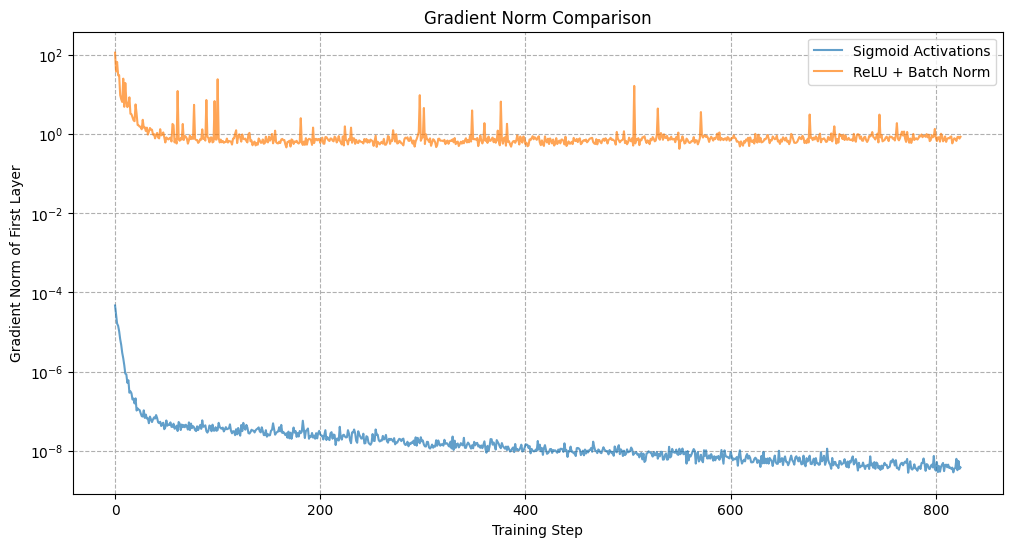


--- Analysis of Results ---
Average Gradient Norm (Sigmoid): 0.0000001840
Average Gradient Norm (ReLU+BN): 1.3370


In [10]:
plt.figure(figsize=(12, 6))
plt.plot(sigmoid_grad_norms, label='Sigmoid Activations', alpha=0.7)
plt.plot(relu_bn_grad_norms, label='ReLU + Batch Norm', alpha=0.7)
plt.xlabel('Training Step')
plt.ylabel('Gradient Norm of First Layer')
plt.title('Gradient Norm Comparison')
plt.yscale('log') # Use a log scale to see the huge difference
plt.legend()
plt.grid(True, which="both", ls="--")
plt.show()

print("\n--- Analysis of Results ---")
print(f"Average Gradient Norm (Sigmoid): {np.mean(sigmoid_grad_norms):.10f}")
print(f"Average Gradient Norm (ReLU+BN): {np.mean(relu_bn_grad_norms):.4f}")

In [11]:
class AblationFCNN(nn.Module):
    def __init__(self, input_size, num_classes, dropout_p=0.5):
        super(AblationFCNN, self).__init__()

        hidden_dim = 512

        layers = [
            nn.Flatten(),
            nn.Linear(input_size, hidden_dim)
        ]

        # 8 hidden layers
        for _ in range(8):
            layers.append(nn.ReLU())
            layers.append(nn.BatchNorm1d(hidden_dim))
            layers.append(nn.Dropout(p=dropout_p))
            layers.append(nn.Linear(hidden_dim, hidden_dim))

        # Output layer
        layers.append(nn.ReLU())
        layers.append(nn.Linear(hidden_dim, num_classes))

        self.layers = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        return self.layers(x)


In [12]:
def run_experiment(model, optimizer, criterion, num_epochs=10):
    model.to(DEVICE)
    best_acc = 0.0

    for epoch in range(num_epochs):
        # Training phase
        model.train()
        for inputs, labels in dataloaders['train']:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        # Validation phase
        model.eval()
        running_corrects = 0
        with torch.no_grad():
            for inputs, labels in dataloaders['val']:
                inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                running_corrects += torch.sum(preds == labels.data)

        epoch_acc = running_corrects.double() / dataset_sizes['val']
        print(f"Epoch {epoch+1}/{num_epochs}, Val Accuracy: {epoch_acc:.4f}")

        if epoch_acc > best_acc:
            best_acc = epoch_acc

    print(f"--- Experiment Finished. Best Validation Accuracy: {best_acc:.4f} ---")
    return best_acc.item()

In [13]:
results = {}
NUM_ABLATION_EPOCHS = 10

def run_ablation(name, dropout, lr, optimizer_type="adam"):
    print("\n" + "="*50)
    print(f"RUNNING: {name}")
    print("="*50)

    model = AblationFCNN(input_size, num_classes, dropout_p=dropout)

    # Select optimizer
    if optimizer_type == "adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif optimizer_type == "sgd":
        optimizer = optim.SGD(model.parameters(), lr=lr)
    else:
        raise ValueError("Unknown optimizer")

    final_acc = run_experiment(
        model,
        optimizer,
        criterion,
        num_epochs=NUM_ABLATION_EPOCHS
    )

    results[name] = {
        "Configuration": f"{optimizer_type.upper()}, LR={lr}, Dropout={dropout}",
        "Final Val Accuracy": final_acc
    }


# 1 Baseline
run_ablation(
    name="Baseline",
    dropout=0.5,
    lr=1e-3,
    optimizer_type="adam"
)

# 2 No dropout
run_ablation(
    name="No Dropout",
    dropout=0.0,
    lr=1e-3,
    optimizer_type="adam"
)

# 3 High LR
run_ablation(
    name="High LR",
    dropout=0.5,
    lr=1e-2,
    optimizer_type="adam"
)

# 4 Low LR
run_ablation(
    name="Low LR",
    dropout=0.5,
    lr=1e-4,
    optimizer_type="adam"
)

# 5 SGD
run_ablation(
    name="Vanilla SGD",
    dropout=0.5,
    lr=1e-3,
    optimizer_type="sgd"
)



RUNNING: Baseline
Epoch 1/10, Val Accuracy: 0.2560
Epoch 2/10, Val Accuracy: 0.2980
Epoch 3/10, Val Accuracy: 0.2940
Epoch 4/10, Val Accuracy: 0.3320
Epoch 5/10, Val Accuracy: 0.3420
Epoch 6/10, Val Accuracy: 0.3560
Epoch 7/10, Val Accuracy: 0.3640
Epoch 8/10, Val Accuracy: 0.3300
Epoch 9/10, Val Accuracy: 0.3640
Epoch 10/10, Val Accuracy: 0.3540
--- Experiment Finished. Best Validation Accuracy: 0.3640 ---

RUNNING: No Dropout
Epoch 1/10, Val Accuracy: 0.3040
Epoch 2/10, Val Accuracy: 0.3600
Epoch 3/10, Val Accuracy: 0.3880
Epoch 4/10, Val Accuracy: 0.3520
Epoch 5/10, Val Accuracy: 0.4000
Epoch 6/10, Val Accuracy: 0.4120
Epoch 7/10, Val Accuracy: 0.3780
Epoch 8/10, Val Accuracy: 0.3880
Epoch 9/10, Val Accuracy: 0.3560
Epoch 10/10, Val Accuracy: 0.3420
--- Experiment Finished. Best Validation Accuracy: 0.4120 ---

RUNNING: High LR
Epoch 1/10, Val Accuracy: 0.2480
Epoch 2/10, Val Accuracy: 0.2740
Epoch 3/10, Val Accuracy: 0.2500
Epoch 4/10, Val Accuracy: 0.3020
Epoch 5/10, Val Accuracy

In [14]:
# Convert the results dictionary to a pandas DataFrame for a nice table
results_df = pd.DataFrame.from_dict(results, orient='index')
results_df['Accuracy Change'] = results_df['Final Val Accuracy'] - results_df.loc['Baseline', 'Final Val Accuracy']

# Calculate the impact as the absolute change from baseline
results_df['Impact'] = abs(results_df['Accuracy Change'])

# Sort by impact
results_df = results_df.sort_values(by='Impact', ascending=False)

print("\n\n--- Ablation Study Summary Table ---")
print(results_df)

biggest_impact_factor = results_df.index[0]
print(f"\nConclusion: The factor with the biggest impact on performance was '{biggest_impact_factor}'.")



--- Ablation Study Summary Table ---
                            Configuration  Final Val Accuracy  \
Vanilla SGD    SGD, LR=0.001, Dropout=0.5               0.106   
Low LR       ADAM, LR=0.0001, Dropout=0.5               0.294   
No Dropout    ADAM, LR=0.001, Dropout=0.0               0.412   
High LR        ADAM, LR=0.01, Dropout=0.5               0.334   
Baseline      ADAM, LR=0.001, Dropout=0.5               0.364   

             Accuracy Change  Impact  
Vanilla SGD           -0.258   0.258  
Low LR                -0.070   0.070  
No Dropout             0.048   0.048  
High LR               -0.030   0.030  
Baseline               0.000   0.000  

Conclusion: The factor with the biggest impact on performance was 'Vanilla SGD'.
